# Named Entity Recognition using LSTMs

### Import libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

In [4]:
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


### Explore the Dataset

*Info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [7]:
data = pd.read_csv("./dataset.csv")

In [8]:
data = data.fillna(method="ffill")
data.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [13]:
print("Unique words in corpus:", data["Word"].nunique())
print("Unique tags in corpus:", data["Tag"].nunique())

Unique words in corpus: 35172
Unique tags in corpus: 17


In [15]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [17]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [18]:
num_words, num_tags

(35173, 17)

### Retrieve Sentences and Corresponsing Tags

In [20]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1 
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [21]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [23]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [29]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags) }

In [30]:
word2idx

{'Monte': 1,
 'fluctuating': 2,
 'reassert': 3,
 'Environmental': 4,
 'Coretta': 5,
 'Donors': 6,
 'initially': 7,
 'flood': 8,
 'recording': 9,
 'varies': 10,
 'fall': 11,
 'Flores': 12,
 'Shams': 13,
 'solve': 14,
 'does': 15,
 'adequate': 16,
 'graduation': 17,
 'Adan': 18,
 'hospitals': 19,
 'avoiding': 20,
 'Ivana': 21,
 'left-footed': 22,
 '58-year-old': 23,
 '33.5': 24,
 'Lisbon': 25,
 'Gulbuddin': 26,
 '1890': 27,
 'Tzipi': 28,
 'army': 29,
 'Halfun': 30,
 'Gulu': 31,
 'diminishes': 32,
 'Nightingale': 33,
 'tune': 34,
 'Olmo': 35,
 'some-500': 36,
 'Punjab': 37,
 'Napa': 38,
 'downgrading': 39,
 'prohibiting': 40,
 'recommendations': 41,
 'Nyange': 42,
 'marathoner': 43,
 'overshadowed': 44,
 'Aktham': 45,
 'firearms': 46,
 'headquarters': 47,
 'Popovic': 48,
 'crashed': 49,
 'repays': 50,
 'militarist': 51,
 'consulates': 52,
 'Piemonte': 53,
 'uncommon': 54,
 'Essebar': 55,
 'clouded': 56,
 'aiding': 57,
 'Katharine': 58,
 'coordinator': 59,
 'As-Sultan': 60,
 'uncertainty':

### Padding Input Sentences and Creating Train/Test Splits

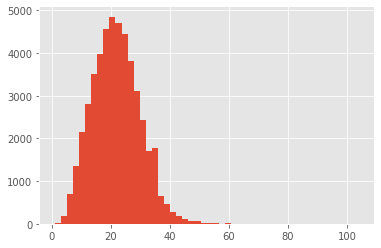

In [37]:
plt.hist([len(s) for s in sentences], bins=50);

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [40]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences ]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

In [41]:
y = [[tag2idx[w[2]] for w in s ] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### Building a Bidirectional LSTM Model

In [44]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [45]:
input_word = Input(shape=(max_len, ))

model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len )(input_word)
model = SpatialDropout1D(0.1)(model)
# Bidirection is used to learn dependcies from all inputs
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758650   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,882,867
Trainable params: 1,882,867
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Training the Model

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

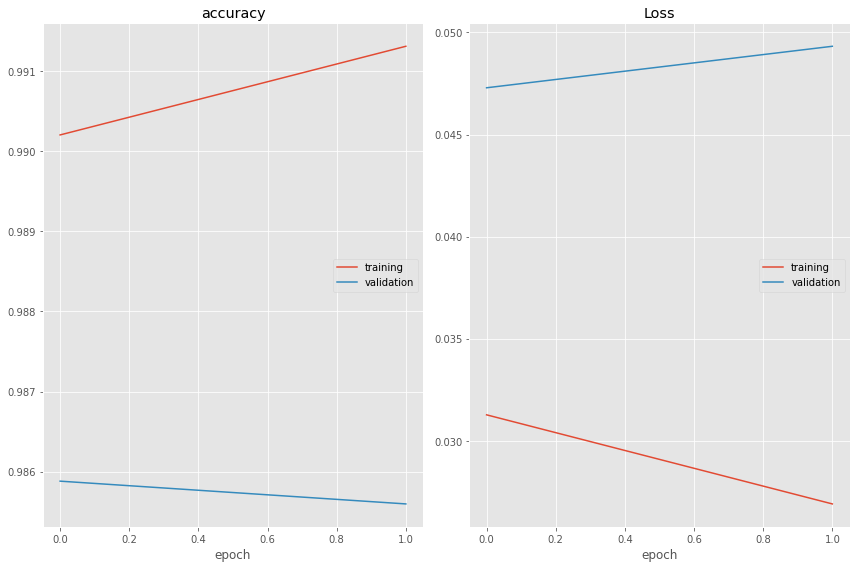

accuracy
	training         	 (min:    0.990, max:    0.991, cur:    0.991)
	validation       	 (min:    0.986, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.027, max:    0.031, cur:    0.027)
	validation       	 (min:    0.047, max:    0.049, cur:    0.049)


In [50]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode="max", restore_best_weights=False)
callbacks= [early_stopping, PlotLossesCallback()]

model.fit(
    X_train, np.array(y_train),
    validation_split=0.15,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### Assessing the Model

In [51]:
model.evaluate(X_test, np.array(y_test))

150/150 [==============================] - 2s 13ms/step - loss: 0.0491 - accuracy: 0.9858


[0.049146804958581924, 0.9858257174491882]

In [60]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "pred"))
print("-"*30)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 pred

------------------------------
The            O	O
U.N.           B-org	B-org
Security       I-org	I-org
Council        I-org	I-org
established    O	O
the            O	O
International  B-org	B-org
Criminal       I-org	I-org
Tribunal       I-org	I-org
for            I-org	I-org
Rwanda         I-org	I-org
in             O	O
November       B-tim	B-tim
,              I-tim	I-tim
1994           I-tim	I-tim
.              O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	O
Siddiqi        O	